In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/Data_new.zip

drive.flush_and_unmount()

Mounted at /content/drive
Archive:  drive/MyDrive/Data_new.zip
   creating: Data_new/images_original/
   creating: Data_new/images_original/blues/
  inflating: Data_new/images_original/blues/blues00000.png  
  inflating: Data_new/images_original/blues/blues00001.png  
  inflating: Data_new/images_original/blues/blues00002.png  
  inflating: Data_new/images_original/blues/blues00003.png  
  inflating: Data_new/images_original/blues/blues00004.png  
  inflating: Data_new/images_original/blues/blues00005.png  
  inflating: Data_new/images_original/blues/blues00006.png  
  inflating: Data_new/images_original/blues/blues00007.png  
  inflating: Data_new/images_original/blues/blues00008.png  
  inflating: Data_new/images_original/blues/blues00009.png  
  inflating: Data_new/images_original/blues/blues00010.png  
  inflating: Data_new/images_original/blues/blues00011.png  
  inflating: Data_new/images_original/blues/blues00012.png  
  inflating: Data_new/images_original/blues/blues00013.png  

In [ ]:
# df = pd.read_csv("Data/features_30_sec.csv")
df = pd.read_csv("features_30_sec.csv")
df = df[['filename','label']]

In [ ]:
df = df[df['filename'] != "jazz.00054.wav"]
df = df.reset_index()
df.pop('index')

0        0
1        1
2        2
3        3
4        4
      ... 
994    994
995    995
996    996
997    997
998    998
Name: index, Length: 999, dtype: int64

In [ ]:
class_name = {}
n = 0
for i in df['label'].unique():
    class_name[i] = n
    n+=1
num_classes = n

In [ ]:
class_name

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [ ]:
idx2genre = {value: key for key, value in class_name.items()}

In [ ]:
df['label'] = df['label'].map(class_name)

In [ ]:
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    df['filename'][i] = "Data_new/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [ ]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 799, 'test': 100, 'val': 100}


In [ ]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [ ]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [ ]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model

In [ ]:
# image shape is (219, 338, 1)

class GenreCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Sequential(
        self.conv3x3(1, 16),
        nn.MaxPool2d((3,3), (2,2)),

        self.conv3x3(16, 32),
        nn.MaxPool2d((2,3), (2,2)),

        self.conv3x3(32, 64),
        nn.MaxPool2d((5,6), (5,6)),

        self.conv3x3(64, 128),
        nn.MaxPool2d((6,6), (5,4)),

        nn.Flatten(),
        nn.Linear(2*128, 128),
        nn.ReLU()
        )

    self.classify = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(128, 10)
        )

    self.apply(self._init_weights)

  def conv3x3(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
        ) 

  def forward(self, input):
    embedding = self.embed(input)
    output = self.classify(embedding)
    return output

  def _init_weights(self, layer):
    if isinstance(layer, (nn.Linear, nn.Conv2d)):
      nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

### Load saved weights

In [ ]:
model = GenreCNN()
saved_dict = torch.load('./weights_best.pth', map_location=torch.device('cpu'))
model.load_state_dict(saved_dict)
# model = model.to(device)

<All keys matched successfully>

In [ ]:
def test_model(model):

    model.eval()   # Set model to evaluate mode

    # t_output = []
    t_pred = []
    y_test = []

    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_test.append(labels)
        
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        
        # t_output.append(outputs)
        t_pred.append(preds)
           
    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
   
    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test, target_names=list(class_name.keys()), zero_division=0))

In [ ]:
torch.cuda.empty_cache() 


Confusion Matrix
[[ 7  0  1  0  0  0  0  0  0  0]
 [ 0 10  2  1  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  1  1  3]
 [ 1  0  0  4  1  0  0  0  1  0]
 [ 0  0  0  2  9  0  1  1  1  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  1]
 [ 0  0  0  3  0  0  0  8  1  1]
 [ 2  0  1  0  0  0  0  0  6  1]
 [ 0  0  1  0  0  0  0  0  0  4]]


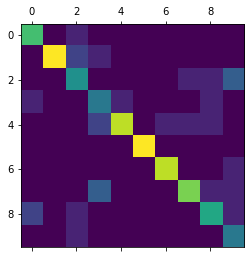


Classification Report
              precision    recall  f1-score   support

       blues       0.70      0.88      0.78         8
   classical       1.00      0.77      0.87        13
     country       0.50      0.50      0.50        10
       disco       0.40      0.57      0.47         7
      hiphop       0.90      0.64      0.75        14
        jazz       1.00      1.00      1.00        10
       metal       0.90      0.90      0.90        10
         pop       0.80      0.62      0.70        13
      reggae       0.60      0.60      0.60        10
        rock       0.40      0.80      0.53         5

    accuracy                           0.72       100
   macro avg       0.72      0.73      0.71       100
weighted avg       0.76      0.72      0.73       100



In [ ]:
test_model(model)

# Recommendation
### Extract song embeddings

In [ ]:
list(model.modules())[1:][0]

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=(2, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): MaxPool2d(kernel_size=(5, 6), stride=(5, 6), padding=0, dilation=1, ceil_mode=False)
  (6): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): 

In [ ]:
my_model = nn.Sequential(*(list(model.modules())[1:])[0]) # strips off last linear layer and dropout layer
class SongEncoderDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': img_name.split('/')[-1].split(".")[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

transformed_dataset = SongEncoderDataset(csv_file=df,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
whole_dataloader = DataLoader(transformed_dataset, batch_size=16,
                        shuffle=False, num_workers=0)

In [ ]:
def song_encoder(model, norm=True):
                
    model.eval()   # Set model to evaluate mode

    song_name = []
    song_encoded = []

    # Iterate over data.
    for inputs, labels in whole_dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs.float())
        temp = outputs.cpu().detach().numpy()
        song_name += list(labels)
        for i in temp:
          if norm:
            song_encoded.append(i/np.linalg.norm(i))  
          else:
            song_encoded.append(i)

    return song_name, song_encoded

song_name, song_encoded = song_encoder(my_model)
song_encoded = np.array(song_encoded)
import pickle
with open('song_embed.pkl', 'wb') as f:
   pickle.dump(song_encoded, f)
with open('song_name.pkl', 'wb') as f:
   pickle.dump(song_name, f)

In [ ]:
import pickle
with open('song_embed.pkl', 'rb') as f:
   song_vec = pickle.load(f)
with open('song_name.pkl', 'rb') as f:
   song_name = pickle.load(f)

In [ ]:
def songRecomendation(song_name, song_embed, new_song, k=5, norm=True):
  if norm:
    ls = np.argpartition(np.dot(song_embed,new_song/np.linalg.norm(new_song)), -k)[-k:]
  else:
    ls = np.argpartition(np.dot(song_embed,new_song), -k)[-k:]
    
  return [song_name[i] for i in ls]

In [ ]:
query = 'rock00088'
q = song_name.index(query)
songRecomendation(song_name, song_vec, song_vec[q], k=5)

['disco00089', 'rock00079', 'disco00072', 'rock00081', 'rock00088']

### TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(song_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tmpdf = df.copy()
tmpdf['names'] = tmpdf['filename']
tmpdf['names'] = tmpdf['names'].apply(lambda x: x.split('/')[-1].split('.')[0])
tmpdf.drop(columns=['filename'], inplace=True)

In [ ]:
tmpdf = tmpdf.set_index('names')
song_label = []
for name in song_name:
  idx = tmpdf.loc[name]['label']
  song_label.append(idx2genre[idx])

tsnedf = pd.DataFrame(song_label, song_name, columns=["genre"])

In [ ]:
colors = ['blue','green', 'red', 'yellow', 'orange', 'cyan', 'pink', 'brown','purple','grey']
colors_dict = dict(zip(list(class_name.keys()), colors))

In [ ]:
import seaborn as sns

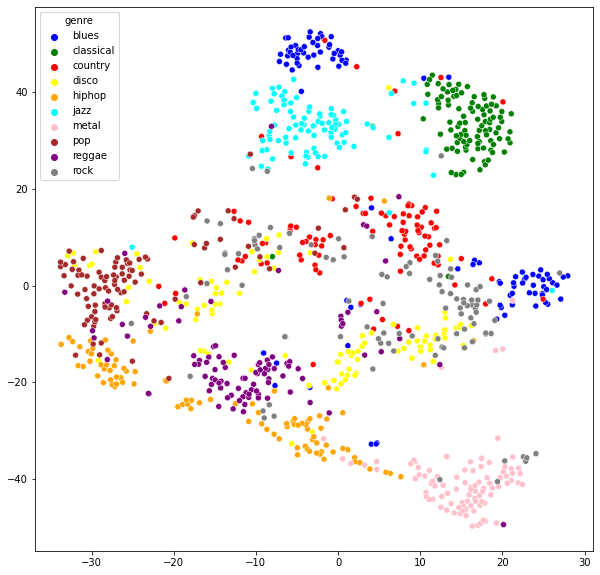

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=embed_tsne[:,0], y=embed_tsne[:,1], hue="genre", data=tsnedf, palette=colors, legend='full')

In [ ]:
tmp_idx = []
tmp = None
for i in range(10):
  start = i*100 
  end = start+10
  tmp_idx += list(range(start,end))
  if tmp is None:
    tmp = embed_tsne[start:end]
  else: tmp += embed_tsne[start:end]

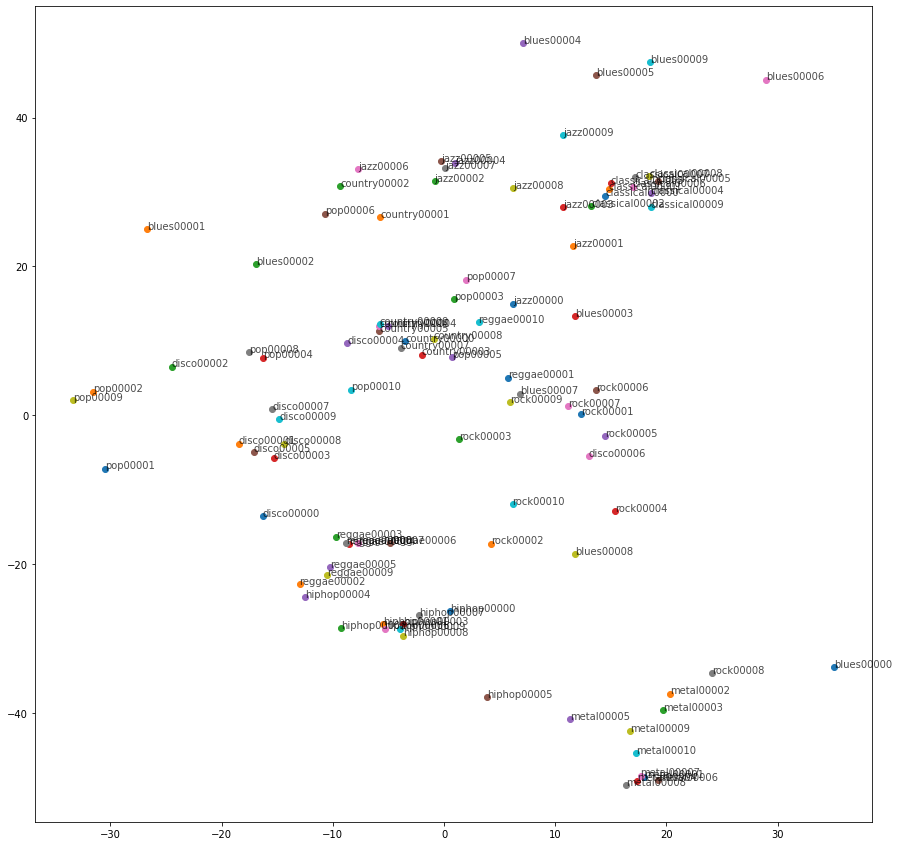

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

for idx in tmp_idx:
  plt.scatter(*embed_tsne[idx, :])
  plt.annotate(song_name[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

### Evaluate embeddings

In [ ]:
def eval_embed(song_name, song_embed):
    score = 0
    dc= {}
    dc_count = {}
    examples = [] 

    for name, embed in zip(song_name, song_embed):
        ans = songRecomendation(song_name, song_embed, embed, k = 6)
        full_ans = ans
        ans = [i[:-5] for i in ans]
        full_name = name
        name = name[:-5]
        if dc.get(name,False) == False:
            dc[name] = 0
            dc_count[name] = 0
        dc_count[name] +=1
        dc[name] += (ans.count(name)-1)/5
        
        score_i = (ans.count(name)-1)/5
        score += score_i

        if score_i <= 0.2 and len(examples)<3 and name=="rock":
          examples.append((full_name, full_ans))

    for i in dc.keys():
        score_i = dc[i]/dc_count[i]
        print(i,"{:.3f}".format(score_i))
    score = score/(len(song_name))
    print("average score : {:.3f}".format(score))
    print('\nlow score examples:', examples)

eval_embed(song_name, song_vec)

blues 0.774
classical 0.960
country 0.616
disco 0.558
hiphop 0.736
jazz 0.867
metal 0.884
pop 0.732
reggae 0.668
rock 0.436
average score : 0.722

low score examples: [('rock00002', ['disco00099', 'disco00066', 'disco00082', 'disco00059', 'disco00049', 'rock00002']), ('rock00003', ['country00084', 'blues00074', 'blues00057', 'blues00002', 'rock00003', 'blues00095']), ('rock00004', ['hiphop00023', 'disco00090', 'disco00087', 'rock00074', 'disco00069', 'rock00004'])]
